In [124]:
from empyrical import max_drawdown
from apippy.api import get_price
import pandas as pd
res = get_price(start_date="20160201", end_date="20250501", type = 'index')

# 中证1000
etf0_data = res.loc[res['order_book_id'] == '000852.XSHG'].sort_values('date')
# 沪深300
etf1_data = res.loc[res['order_book_id'] == '000300.XSHG'].sort_values('date')

In [127]:
etf0_data.head()

,order_book_id,date,volume,low,open,prev_close,high,close,total_turnover
1103,000852.XSHG,2016-02-01,8.684369e+09,7163.9131,7358.7541,7385.7587,7420.4844,7292.6133,1.158881e+11
1075,000852.XSHG,2016-02-02,9.797843e+09,7295.8018,7296.2228,7292.6133,7600.0761,7576.0654,1.329415e+11
179,000852.XSHG,2016-02-03,9.448356e+09,7428.8998,7480.3009,7576.0654,7665.6531,7630.4588,1.256427e+11
823,000852.XSHG,2016-02-04,1.082957e+10,7661.6474,7661.6474,7630.4588,7839.2823,7807.4008,1.479612e+11
1495,000852.XSHG,2016-02-05,8.629786e+09,7716.2066,7828.6103,7807.4008,7856.7348,7718.7083,1.168337e+11


In [33]:
def calculate_metrics(returns):
    """
    Calculates common backtesting metrics.

    Args:
        returns (pd.Series): Series of daily returns.

    Returns:
        dict: Dictionary containing calculated metrics.
    """
    # Ensure returns are not all NaN or zero before calculating metrics
    if returns.isnull().all() or returns.sum() == 0:
         return {
            'Total Return': 0.0,
            'Annualized Return': 0.0,
            'Volatility': 0.0,
            'Sharpe Ratio': 0.0,
            'Max Drawdown': 0.0
         }

    total_return = (1 + returns).prod() - 1 # Correct total return calculation
    # Avoid division by zero or issues with short periods
    if len(returns) == 0:
        annualized_return = 0
    else:
         annualized_return = (1 + total_return) ** (252 / len(returns)) - 1  # Annualize based on actual length

    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe = annualized_return / volatility if volatility != 0 else 0 # Sharpe Ratio (assuming 0 risk-free rate)
    max_dd = max_drawdown(returns)  # Maximum Drawdown

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }


In [34]:
def preprocessing(etf0_data, etf1_data):
    """
    对数据进行预处理
    :param etf0_data: 中证1000数据
    :param etf1_data: 沪深300数据
    :return: 处理后的数据
    """
    etf0_data = etf0_data.copy()
    etf1_data = etf1_data.copy()
    # 将日期列转换为datetime格式
    etf0_data['date'] = pd.to_datetime(etf0_data['date'])
    etf1_data['date'] = pd.to_datetime(etf1_data['date'])
    # 把 order_book_id 列删除
    etf0_data.drop(columns=['order_book_id'], inplace=True)
    etf1_data.drop(columns=['order_book_id'], inplace=True)
    # 将日期列设置为索引
    etf0_data.set_index('date', inplace=True)
    etf1_data.set_index('date', inplace=True)

    # 计算收益率
    etf0_data['return'] = etf0_data['close'].pct_change()
    etf1_data['return'] = etf1_data['close'].pct_change()
    
    # rename
    etf0_data.rename(columns=lambda x: f'etf0_{x}' if x != 'date' else x, inplace=True)
    etf1_data.rename(columns=lambda x: f'etf1_{x}' if x != 'date' else x, inplace=True)

    # 合并数据
    # 按照date列进行合并
    merged_data = pd.merge(etf0_data, etf1_data, left_index=True, right_index=True, how='outer')
    # 添加一列return 差值
    merged_data['return_diff'] = merged_data['etf0_return'] - merged_data['etf1_return']
    # 添加一列三日平均
    merged_data['return_diff_3d_avg'] = merged_data['return_diff'].rolling(window=3).mean()

    # 添加shift之后的return_diff，return_diff_3d_avg
    merged_data['return_diff_shifted'] = merged_data['return_diff'].shift(-1)
    merged_data['return_diff_3d_avg_shifted'] = merged_data['return_diff_3d_avg'].shift(-3)
    return merged_data
ori_data = preprocessing(etf0_data, etf1_data)

In [298]:
def add_feature(data):
    """
    添加特征
    :param data: 处理后的数据
    :return: 添加特征后的数据
    """
    data = data.copy()
    # 根据data 的date 创建一个新的dataFrame
    feature = pd.DataFrame(index=data.index)

    # 添加因子：计算过去5天、10天、20天的平均收益率
    for window in [5, 10, 20]:
        feature[f'mean_return_{window}d'] = data['return_diff'].rolling(window=window).mean()
    
    # 计算过去5天、10天、20天的波动率（标准差）
    for window in [5, 10, 20]:
        feature[f'volatility_{window}d'] = data['return_diff'].rolling(window=window).std()

    # 计算过去5天、10天、20天的偏度（skewness）
    for window in [5, 10, 20]:
        feature[f'skew_{window}d'] = data['return_diff'].rolling(window=window).skew()

    # for window in [5, 10, 20]:
    #     for name in ['etf0', 'etf1']:
    #         feature[f'{name}_std_{window}d'] = data[f'{name}_return'].rolling(window=window).std()
    
    # 计算过去5天、10天、20天的最大收益率
    for window in [5, 10, 20]:
        feature[f'max_return_{window}d'] = data['return_diff'].rolling(window=window).max()

    # 计算过去5天、10天、20天的最小收益率
    for window in [5, 10, 20]:
        feature[f'min_return_{window}d'] = data['return_diff'].rolling(window=window).min()
    
    data['etf0_volume_pct'] = data['etf0_volume'].pct_change()
    data['etf1_volume_pct'] = data['etf1_volume'].pct_change()
    for window in [5, 10, 20]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_mean_price_{window}d'] = data[f'{name}_close'].rolling(window=window).mean()
    for name in ['etf0', 'etf1']:
        feature[f'{name}_mean_break'] = feature[f'{name}_mean_price_5d'] - feature[f'{name}_mean_price_20d']
    for window in [5, 10, 20]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_volume_pct_{window}d'] = data[f'{name}_volume_pct'].rolling(window=window).mean()
            # 当日除以window平均
            feature[f'{name}_relative_volume_{window}d'] = data[f'{name}_volume'] / data[f'{name}_volume'].rolling(window=window).mean()
    # for window in [5, 10, 20]:
    #     for name in ['etf0', 'etf1']:
    #         feature[f'{name}_total_turnover_{window}d'] = data[f'{name}_total_turnover'].rolling(window=window).mean()
    # 因子进行z-score标准化， 用rolling防止泄露
    for col in feature.columns:
        feature[col] = (feature[col] - feature[col].rolling(window=30).mean()) / feature[col].rolling(window=30).std()
    return feature
features = add_feature(ori_data)


In [277]:
# 根据return_diff 做因子筛选
def feature_selection(data, feature, target='return_diff_shifted'):
    """
    特征选择
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :return: 选择的特征
    """
    data = data.copy()
    # 计算相关系数
    corr = feature.corrwith(data[target])
    # print(corr.sort_values(ascending=False))
    # 选择相关系数大于0.05的特征
    selected_features = corr[abs(corr) > 0.05].index.tolist()
    return selected_features
selected_features = feature_selection(ori_data, features)

len(selected_features)

17

In [299]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # 确保导入 pandas
from tqdm import tqdm

def train_lgbm_model_improved(data, feature, selected_features, target='return_diff_shifted',
                              start_date='2016-01-01', end_date='2023-12-01',
                              test_size=0.2, random_state=42,
                              # LGBM 参数 - 可以根据需要调整和传入
                              n_estimators=2000, # 增加 n_estimators，配合 early_stopping
                              learning_rate=0.001,
                              max_depth=-1, # 默认 -1 表示没有限制
                              num_leaves=31, # 默认值
                              min_child_samples=20, # 默认值
                              subsample=0.8, # 数据子采样比例
                              colsample_bytree=0.8, # 特征子采样比例
                              reg_alpha=0.1, # L1 正则化
                              reg_lambda=0.1, # L2 正则化
                              early_stopping_rounds=50, # 提前停止的轮数
                              verbose_eval=100 # 每隔多少轮打印评估结果，-1为不打印，0为打印所有
                             ):
    """
    训练LGBM模型（改进版）
    :param data: 处理后的数据 (Pandas DataFrame, 索引为日期时间)
    :param feature: 添加特征后的数据 (Pandas DataFrame, 索引为日期时间)
    :param selected_features: 选择的特征列表
    :param target: 目标变量列名
    :param start_date: 数据开始日期
    :param end_date: 数据结束日期
    :param test_size: 测试集比例
    :param random_state: 随机种子
    :param n_estimators: 树的数量
    :param learning_rate: 学习率
    :param max_depth: 树的最大深度
    :param num_leaves: 每棵树的叶子节点数
    :param min_child_samples: 叶子节点最小样本数
    :param subsample: 数据子采样比例
    :param colsample_bytree: 特征子采样比例
    :param reg_alpha: L1 正则化系数
    :param reg_lambda: L2 正则化系数
    :param early_stopping_rounds: 提前停止的轮数
    :param verbose_eval: 控制LGBM评估日志的频率
    :return: 训练好的模型, RMSE值
    """
    data_df = data.copy()
    feature_df = feature.copy()

    # 确保索引是 DateTimeIndex 类型，如果不是，请先转换
    if not isinstance(data_df.index, pd.DatetimeIndex):
        data_df.index = pd.to_datetime(data_df.index)
    if not isinstance(feature_df.index, pd.DatetimeIndex):
        feature_df.index = pd.to_datetime(feature_df.index)

    # 选择数据范围
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    data_df = data_df[(data_df.index >= start_dt) & (data_df.index <= end_dt)]
    feature_df = feature_df[(feature_df.index >= start_dt) & (feature_df.index <= end_dt)]

    # 划分数据集
    X = feature_df[selected_features]
    y = data_df[target]

    # 删除缺失值 (保持 X 和 y 的索引一致)
    # 先合并再删除，确保对齐
    temp_df = pd.concat([X, y], axis=1).dropna()
    X = temp_df[selected_features]
    y = temp_df[target]

    if X.empty or y.empty:
        print("数据为空，请检查日期范围、特征选择或缺失值处理。")
        return None, float('nan')

    # 划分训练集和测试集
    # 对于时间序列数据，更好的做法是不打乱顺序地划分，或者使用 TimeSeriesSplit
    # 这里仍然使用 train_test_split 作为示例，但可以考虑 shuffle=False
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True) # shuffle=True 是默认行为

    # 创建LGBM模型实例
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=random_state,
        verbose=verbose_eval, # -1表示不输出
    )

    # LightGBM Callbacks
    callbacks = []
    if early_stopping_rounds > 0:
        callbacks.append(lgb.early_stopping(stopping_rounds=early_stopping_rounds,
                                            verbose=1)) # verbose=1 会打印early stopping信息
    
    # verbose_eval 控制LightGBM内置的日志输出频率
    # -1: 不输出; 0: 每轮都输出; N: 每N轮输出
    # 我们使用 lgb.log_evaluation() 来替代 fit 中的 verbose 参数，以更好地控制
    if verbose_eval >= 0:
        callbacks.append(lgb.log_evaluation(period=verbose_eval if verbose_eval > 0 else 1))


    # 使用 lgb.ProgressBar() (如果可用且希望用这个替代tqdm)
    # 或者，可以继续使用您之前的 tqdm_callback_wrapper，但要注意它与early_stopping的交互
    # 如果使用 early_stopping, 总迭代次数可能小于 n_estimators
    # tqdm 的 total 可以设置为 n_estimators，如果提前停止，进度条不会填满
    
    print(f"开始训练模型，最多 {n_estimators} 轮迭代...")
    with tqdm(total=n_estimators, desc="LGBM Training", unit="iteration") as pbar:
        def tqdm_update_callback(env):
            pbar.update(1)
            # 如果需要，可以在这里添加更多逻辑，比如更新 pbar 的描述
            pbar.set_description(f"Iter: {env.iteration}, Eval RMSE: {env.evaluation_result_list[0][2]:.4f}")

        final_callbacks = callbacks + [tqdm_update_callback]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], # 同时评估训练集和测试集
            eval_names=['Train', 'Test'], # 命名评估集合
            eval_metric='rmse', # 评估指标
            callbacks=final_callbacks
        )

    # tqdm_bar.close() # 如果使用外部的 tqdm_bar

    # 如果发生了提前停止，获取最佳迭代次数
    if early_stopping_rounds > 0 and model.best_iteration_ is not None:
        print(f"模型在第 {model.best_iteration_} 轮迭代时达到最佳性能 (提前停止).")
        # 使用最佳迭代次数的模型进行预测（LGBM fit 后，模型已经是最佳迭代次数状态）
    
    # 预测
    y_pred = model.predict(X_test)

    # 计算均方根误差
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Test RMSE: {rmse:.4f}')

    return model, rmse


# if model:
#     print("模型训练完成。")
#     # 可以查看特征重要性
#     # lgb.plot_importance(model, max_num_features=20)
#     # plt.show()

In [131]:
# 使用lgb，使用选择的特征来回归return_diff
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

def train_model(data, feature, selected_features, target='return_diff_shifted',
                start_date='2016-01-01', end_date='2023-12-01'):
    """
    训练模型
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :param selected_features: 选择的特征
    :return: 模型
    """
    data = data.copy()
    feature = feature.copy()
    # 选择数据范围
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    data = data[(data.index >= start_date) & (data.index <= end_date)]
    feature = feature[(feature.index >= start_date) & (feature.index <= end_date)]
    
    # 划分数据集
    X = feature[selected_features]
    y = data[target]
    
    # 删除缺失值
    X = X.dropna()
    y = y[X.index]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建lgb模型
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    # 创建 tqdm 进度条
    tqdm_callback = lgb.callback.log_evaluation(period=10)  # 每 10 次迭代打印日志
    tqdm_bar = tqdm(total=model.n_estimators, desc="Training Progress", position=0, leave=True)
    
    def tqdm_callback_wrapper(env):
        tqdm_bar.update(env.iteration - tqdm_bar.n)
    # 训练模型
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[tqdm_callback_wrapper]
    )
    tqdm_bar.close()
    # 预测
    y_pred = model.predict(X_test)
    
    # 计算均方根误差
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f'RMSE: {rmse}')
    
    return model
# model = train_model(ori_data, features, selected_features, target = 'return_diff_shifted',)

In [300]:
def signal_generation(data, feature, selected_features, target='return_diff_shifted', smooth = None):
    """
    信号生成
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :param selected_features: 选择的特征
    :return: 加了信号的data
    """
    data = data.copy()
    feature = feature.copy()
    model, rmse = train_lgbm_model_improved(
        ori_data, features, selected_features,
        target='return_diff_shifted',
        n_estimators=3000,
        learning_rate=0.005,
        num_leaves=20,
        max_depth=5,
        min_child_samples=30,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=0.5,
        reg_lambda=0.5,
        early_stopping_rounds=100,
        verbose_eval=-1
    )
    # model = train_model(data, feature, selected_features, target = target)
    # 预测
    X = feature[selected_features]
    y_pred = model.predict(X)
    if smooth is not None:
        # 使用smooth进行平滑
        y_pred = pd.Series(y_pred, index=X.index).rolling(window=smooth).mean()
        y_pred = y_pred.fillna(0)
    # 将预测结果添加到data中
    # 已经shift过了，所以不需要再shift
    data['signal'] = y_pred
    # data['signal'] = np.where(data['predicted_return'] > 0, 1, -1)
    
    return data, model


In [248]:
import matplotlib.pyplot as plt
def run_backtest(data, start_date, verbose = 3, end_date = None, thresh = 0, fees = True):
    """
    回测
    :param start_date: 开始日期
    :param end_date: 结束日期
    :param data: 处理后的数据
    :param verbose: 是否打印回测结果
    :return: 回测结果
    """
    # 判断data是否有signal列
    if 'signal' not in data.columns:
        raise ValueError("data must contain 'signal' column")
    data = data.copy()
    
    # 选择数据范围
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date) if end_date else data.index[-1]

    data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    # 好像有点问题
    # data['etf0_daily_return'] = data['etf0_close'] / data['etf0_prev_close'] - 1
    # data['etf1_daily_return'] = data['etf1_close'] / data['etf1_prev_close'] - 1

    data['etf0_daily_return'] = data['etf0_close'].pct_change().fillna(0)
    data['etf1_daily_return'] = data['etf1_close'].pct_change().fillna(0)
    # thresh= 0.0015
    conditions = [
        (data['signal'] >= thresh),  
        (data['signal'] < thresh), 
    ]
    choices = [
        data['etf0_daily_return'],  # 买入中证1000
        data['etf1_daily_return'],   # 买入沪深300
    ]
    
    data['strategy_daily_return'] = np.select(conditions, choices, default=0)

    data['signal_change'] = ((data['signal']-thresh) * ((data['signal']-thresh).shift(1)) < 0).astype(int)
    if fees:
        data['strategy_daily_return'] = (1 + data['strategy_daily_return'])* np.where(data['signal_change'] == 1, (1 - 0.001)**2, 1) - 1
    data['strategy_cumulative'] = (1 + data['strategy_daily_return']).cumprod() - 1

    data['benchmark_daily_return'] = data['etf0_close'].pct_change().fillna(0)
    data['benchmark_cumulative'] = (1 + data['benchmark_daily_return']).cumprod() - 1

    data['profit_cumulative'] = data['strategy_cumulative'] - data['benchmark_cumulative']
    if verbose >= 2:
        plt.figure(figsize=(12, 6))

        # Plot strategy cumulative return
        plt.plot(data.index, data['strategy_cumulative'], label='Strategy')
        plt.plot(data.index, data['profit_cumulative'], label='Profit (Strategy - Benchmark)', linestyle='--')
        if verbose >= 3:
        # Highlight different positions with colors
        # signale 是1绿色买中证1000，signal是-1 红色买沪深300
            for i in range(len(data) - 1):
                # if data['shifted_signal'].iloc[i] == 0:
                #     plt.axvspan(data.index[i], data.index[i + 1], color='gray', alpha=0.2, label='Cash Position' if i == 0 else None)
                if data['signal'].iloc[i] >= thresh:
                    plt.axvspan(data.index[i], data.index[i + 1], color='green', alpha=0.2)
                elif data['signal'].iloc[i] < thresh:
                    plt.axvspan(data.index[i], data.index[i + 1], color='red', alpha=0.2)

        # Plot benchmark cumulative return
        plt.plot(data.index, data['benchmark_cumulative'], label='Benchmark (Buy & Hold ETF0)')
        
        
        plt.legend()
        plt.title('Strategy vs Benchmark Cumulative Return')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.show()
    strategy_metrics = calculate_metrics(data['strategy_daily_return'])
    benchmark_metrics = calculate_metrics(data['benchmark_daily_return']) # Use the pct_change series for benchmark metrics
    if verbose >= 1:
        print("\n--- Strategy Metrics ---")
        for metric, value in strategy_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\n--- Benchmark Metrics (Buy & Hold ETF0) ---")
        for metric, value in benchmark_metrics.items():
            print(f"{metric}: {value:.4f}")


    return data, strategy_metrics, benchmark_metrics

In [301]:
target = 'return_diff_shifted'
# selected_features = feature_selection(ori_data, features)
selected_features = feature_selection(ori_data, features, target=target)
# selected_features = features.columns.tolist()
signaled_data, output_model = signal_generation(ori_data, features, selected_features, target=target, smooth=3)


开始训练模型，最多 3000 轮迭代...


LGBM Training:   0%|          | 0/3000 [00:00<?, ?iteration/s]

Iter: 83, Eval RMSE: 0.0091:   3%|▎         | 84/3000 [00:00<00:06, 419.14iteration/s]

Training until validation scores don't improve for 100 rounds


Iter: 734, Eval RMSE: 0.0090:  24%|██▍       | 735/3000 [00:01<00:04, 482.03iteration/s]


Early stopping, best iteration is:
[635]	Train's rmse: 0.0090103	Train's l2: 8.11855e-05	Test's rmse: 0.00934958	Test's l2: 8.74146e-05
模型在第 635 轮迭代时达到最佳性能 (提前停止).
Test RMSE: 0.0093


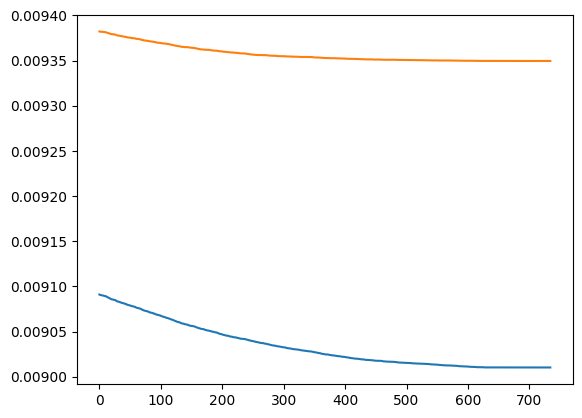

In [302]:
plt.plot(output_model.evals_result_['Train']['rmse'], label='Train RMSE')
plt.plot(output_model.evals_result_['Test']['rmse'], label='Test RMSE')

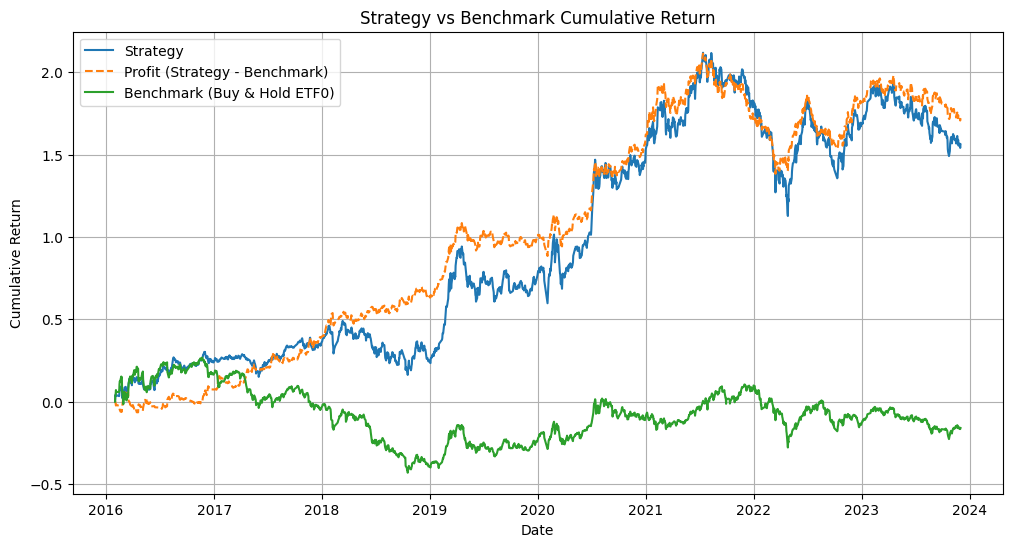


--- Strategy Metrics ---
Total Return: 1.5610
Annualized Return: 0.1325
Volatility: 0.1942
Sharpe Ratio: 0.6822
Max Drawdown: -0.3178

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: -0.1594
Annualized Return: -0.0227
Volatility: 0.2297
Sharpe Ratio: -0.0989
Max Drawdown: -0.5511


In [303]:
# 训练集
_, _ ,_ = run_backtest(
    data = signaled_data,
    start_date = '2016-01-01',
    end_date = '2023-12-01',
    verbose = 2,
    # fees= False
)

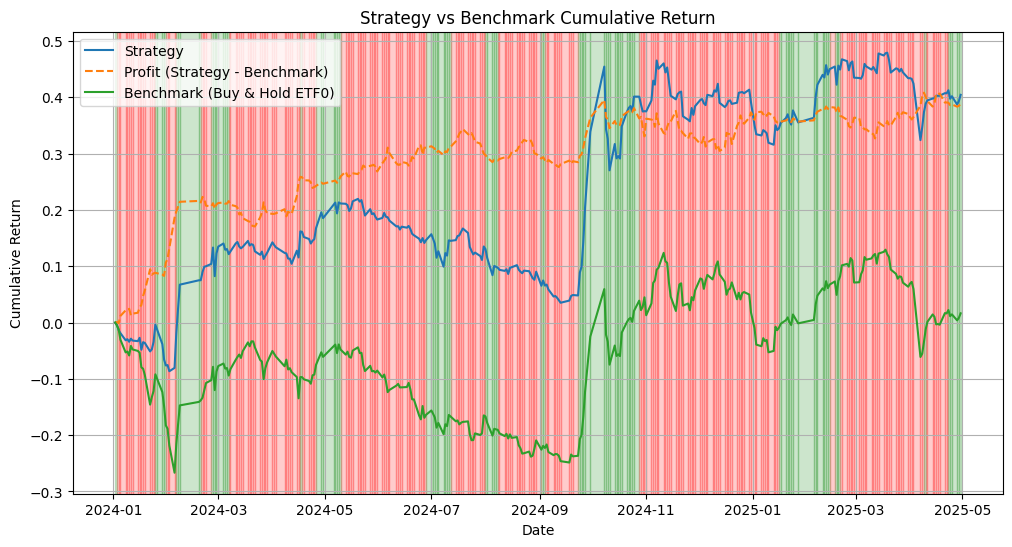


--- Strategy Metrics ---
Total Return: 0.4043
Annualized Return: 0.3066
Volatility: 0.2636
Sharpe Ratio: 1.1630
Max Drawdown: -0.1512

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: 0.0163
Annualized Return: 0.0128
Volatility: 0.3280
Sharpe Ratio: 0.0390
Max Drawdown: -0.2667


In [304]:
backtest_results, strat_metrics, bench_metrics = run_backtest(
    data = signaled_data,
    start_date='2024-01-01',
    end_date='2025-12-01',
    verbose = 3,
    # fees = False
)

In [220]:
# 看看有多少signal是正的
(backtest_results['signal']>0).value_counts()

signal
False    233
True      87
Name: count, dtype: int64

In [254]:
backtest_results['signal_change'].sum()

26

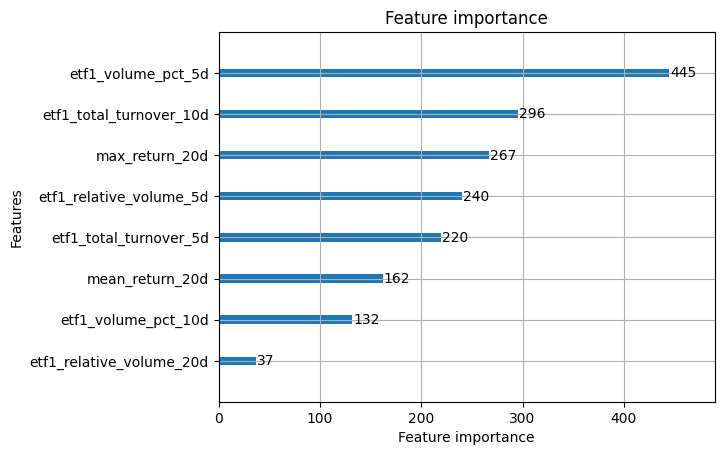

In [283]:

# 可以查看特征重要性
lgb.plot_importance(output_model, max_num_features=20)
plt.show()